# Сегментация

## Локализация

Сегментация как и детекция является способом локализации объектов, но есть и отличия, если в детекции мы локализуем объект с помощью bounding boxes, то в сегментации мы каждому пикселю изображение ставим в соответствие его класс

<img src="./img/segmentation_detection_cls.jpg">

Сегментация используется вместо детекции используется всегда, когда нам важна площадь объекта, например

- медицинские снимки <img src="./img/medical_seg.png">

- спутниковые снимки
<img src="./img/map_seg.jpg">

- Или когда мы хотим поменять фон изображения

<img src="./img/background_seg.jpg">

## Виды сегментации

- semantic segmentation - каждому пикселю (кроме фона) ставится в соответствие номер класса
- instance segmentation - разделяются маски разных экземпляров одного класса
- panoptic segmentation - объеденение instance segmentation для искомых объектов и semantic segmentation для фона

<img src="./img/segmentation_types.png">

## Semantic segmentation

Семантическая сегментация аналогична попиксельной классификации

- вход изображение
- выход маска где каждому пикселю изображения соответствует какой либо класс

Например, у нас имеется изображение, например машины и нужно отделить ее от фона

<img src="./img/carvana.jpeg">

В маске всего 2 класса фон и объект

<img src="./img/carvana_true.png">

Мы предсказываем маску с какой то вероятностью

<img src="./img/carvana_pred.png">

Вопрос, какую функцию потерь использовать чтобы обучить модель?

Первая мысль использовать стандартную Binary cross entropy в нашем примере или Cross entropy при мультиклассе

$$\large{BCE = -y log \hat{y}} - (1 - y) log (1 - \hat{y})$$

Считаем лосс в каждом пикселе и усредняем по площади

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
image_width = 640
image_height = 480

true_mask = torch.randint(0, 2, size=(1, image_height, image_width)).float()
pred_classes = torch.randint(0, 2, size=(1, image_height, image_width))
pred_mask = (1 - pred_classes) * 0.4 + pred_classes * 0.6

criteria = nn.BCELoss()

In [4]:
criteria(pred_mask, true_mask)

tensor(0.7136)

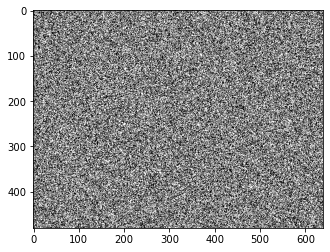

In [6]:
plt.imshow(true_mask[0], cmap="gray")

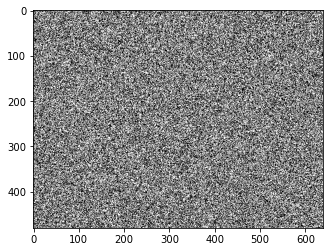

In [7]:
plt.imshow(pred_mask[0], cmap="gray")

Какие проблемы с таким подходом?

<img src="./img/seg_size.png">

Аналогично задаче детекции, может быть сильный дисбаланс классов

Возможные решения:
- Focal loss
- Взвешенный bce
- Другие лоссы

In [8]:
from functools import partial
import torch.nn.functional as F


class FocalLoss(nn.Module):

    def __init__(
            self,
            alpha = None, # label smothing считаем разметку неточной
            gamma = 2., # степерь гамма из фокал лосса
            ignore_index = None, # какие классы мы игнорируем
            reduction = "mean", # как аггрегируем функцию потерь
            normalized = False, # нормировка по весам фокал лосса
            reduced_threshold = None, # ограничение вероятности снизу для слишком редких объектов
    ):

        super().__init__()

        self.ignore_index = ignore_index
        self.focal_loss_fn = partial(
            focal_loss,
            alpha=alpha,
            gamma=gamma,
            reduced_threshold=reduced_threshold,
            reduction=reduction,
            normalized=normalized,
        )

    def forward(self, y_pred, y_true):

        num_classes = y_pred.size(1)
        loss = torch.FloatTensor([0]).squeeze().to(y_pred.device)

        # Filter anchors with -1 label from loss computation
        not_ignored = None
        if self.ignore_index is not None:
            not_ignored = y_true != self.ignore_index

        for cls in range(num_classes):
            cls_y_true = (y_true == cls).long()
            cls_y_pred = y_pred[:, cls, ...]

            if self.ignore_index is not None:
                cls_y_true = cls_y_true[not_ignored]
                cls_y_pred = cls_y_pred[not_ignored]

            loss += self.focal_loss_fn(cls_y_pred, cls_y_true)

        return loss


def focal_loss(
        output,
        target,
        gamma = 2.0,
        alpha = 0.25,
        reduction = "mean",
        normalized = False,
        reduced_threshold = None,
        eps = 1e-6,
):
    target = target.type(output.type())

    logpt = F.binary_cross_entropy_with_logits(output, target, reduction="none")
    pt = torch.exp(-logpt)

    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * logpt

    if alpha is not None:
        loss *= alpha * target + (1 - alpha) * (1 - target)

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss /= norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss

In [9]:
ce_pred = torch.cat([
    1 - pred_mask.view(1, 1, image_height, image_width),
    pred_mask.view(1, 1, image_height, image_width)
], dim = 1) 

In [10]:
loss = FocalLoss()

In [11]:
loss(ce_pred, true_mask.view(1, image_height, image_width).long())

tensor(0.4487)

In [12]:
loss = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.45, 0.55]))

In [13]:
loss(ce_pred, true_mask.view(1, image_height, image_width).long())

tensor(0.6982)

## Архитектура модели

Интерфейс
- вход $H*W*C$
- выход - К масок $H*W$

### Fully-Convolutional Network (FCN) (2014)

- Backbone (VGG)
- Upsampling для приведения к исходному размеру

In [14]:
from torchvision.models import vgg16_bn

In [15]:
image = torch.rand(1, 3, 480, 640)

In [17]:
model = vgg16_bn().features

In [18]:
model(image).shape

torch.Size([1, 512, 15, 20])

In [19]:
640 / 20, 480 / 15

(32.0, 32.0)

In [26]:
class FCN(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        self.model = vgg16_bn().features
        self.predictor = nn.Conv2d(512, n_classes, kernel_size=1)
        
    def forward(self, x):
        x = self.model(x)
        x = self.predictor(x)
        x = F.interpolate(x, scale_factor=32)
        return x

In [27]:
model = FCN(10)

In [28]:
model(image).shape

torch.Size([1, 10, 480, 640])

#### Проблемы

- Узкое бутылочное горлышко
- Резкое увеличение H/W

### Interlude

Как увеличить H/W?
- Upsampling
- Transposed convoulutions

#### Upsampling

- nearest neighbor

<img src="./img/nn_upsample.png">

- bilinear

<img src="./img/bilinear_upsample.webp">

<img src="./img/upsample_methods.png">

## Transposed Conv

Работает аналогично свертке но наоборот увеличивает изображение

- Вместо "сворачивания" с ядром (как в обычном ConvLayer) происходит "разворачивание" входного сигнала
- Значения входного сигнала выступают весами перед ядром транспонированной свертки

<img src="./img/transp_conv.png">

- В некоторых случаях может появляться "шахматный" паттерн в выходном сигнале
- <a href="https://distill.pub/2016/deconv-checkerboard/">Deconvolution and Checkerboard Artifacts</a>


### SegNet (2015)

- <a href="https://www.google.com/url?q=https://paperswithcode.com/paper/segnet-a-deep-convolutional-encoder-decoder&sa=D&source=editors&ust=1700561266684555&usg=AOvVaw3t3_Do6UypngMglu4zPJW0">SegNet: A Deep Convolutional Encoder-Decoder Architecture</a>
- Симметричная архитектура вида Encoder-Decoder
- Постепенный Upsampling

<img src="./img/segnet.png">


In [55]:
class SegNet(nn.Module):

    def __init__(self, in_chn=3, out_chn=32, BN_momentum=0.5):
        super(SegNet, self).__init__()

        #SegNet Architecture
        #Takes input of size in_chn = 3 (RGB images have 3 channels)
        #Outputs size label_chn (N # of classes)

        #ENCODING consists of 5 stages
        #Stage 1, 2 has 2 layers of Convolution + Batch Normalization + Max Pool respectively
        #Stage 3, 4, 5 has 3 layers of Convolution + Batch Normalization + Max Pool respectively

        #General Max Pool 2D for ENCODING layers
        #Pooling indices are stored for Upsampling in DECODING layers

        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True) 

        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)


        #DECODING consists of 5 stages
        #Each stage corresponds to their respective counterparts in ENCODING

        #General Max Pool 2D/Upsampling for DECODING layers
        self.MaxDe = nn.MaxUnpool2d(2, stride=2) 

        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)

        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)

        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)

        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)

        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)
        self.BNDe11 = nn.BatchNorm2d(self.out_chn, momentum=BN_momentum)

    def forward(self, x):

        #ENCODE LAYERS
        #Stage 1
        x = F.relu(self.BNEn11(self.ConvEn11(x))) 
        x = F.relu(self.BNEn12(self.ConvEn12(x))) 
        x, ind1 = self.MaxEn(x)
        size1 = x.size()

        #Stage 2
        x = F.relu(self.BNEn21(self.ConvEn21(x))) 
        x = F.relu(self.BNEn22(self.ConvEn22(x))) 
        x, ind2 = self.MaxEn(x)
        size2 = x.size()

        #Stage 3
        x = F.relu(self.BNEn31(self.ConvEn31(x))) 
        x = F.relu(self.BNEn32(self.ConvEn32(x))) 
        x = F.relu(self.BNEn33(self.ConvEn33(x)))   
        x, ind3 = self.MaxEn(x)
        size3 = x.size()

        #Stage 4
        x = F.relu(self.BNEn41(self.ConvEn41(x))) 
        x = F.relu(self.BNEn42(self.ConvEn42(x))) 
        x = F.relu(self.BNEn43(self.ConvEn43(x)))   
        x, ind4 = self.MaxEn(x)
        size4 = x.size()

        #Stage 5
        x = F.relu(self.BNEn51(self.ConvEn51(x))) 
        x = F.relu(self.BNEn52(self.ConvEn52(x))) 
        x = F.relu(self.BNEn53(self.ConvEn53(x)))   
        x, ind5 = self.MaxEn(x)
        size5 = x.size()

        #DECODE LAYERS
        #Stage 5
        x = self.MaxDe(x, ind5, output_size=size4)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))

        #Stage 4
        x = self.MaxDe(x, ind4, output_size=size3)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))

        #Stage 3
        x = self.MaxDe(x, ind3, output_size=size2)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))

        #Stage 2
        x = self.MaxDe(x, ind2, output_size=size1)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))

        #Stage 1
        x = self.MaxDe(x, ind1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)

        x = F.softmax(x, dim=1)

        return x

In [59]:
model = SegNet(3, 10)

### UNet(2015)

- <a href="https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical">U-Net: CNNs for Biomedical Image Segmentation</a>
- Добавили горизонтальные связи к Encoder-Decoder

<img src="./img/unet.jpg">

- Сильное улучшение сегментации на границах объектов
- Всего лишь 30 изображений 512х512 для обучения!

In [56]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [57]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [58]:
model = UNet(3, 10)

### UNet-like

- Из конкретной архитектуры для сегментации UNet давно превратился в "подход" для задач image-to-image:
-- Сегментация (subj)
-- Колоризация (предсказание цветных каналов для grayscale-входа)
-- InPainting ("закрашивание" пустот)
-- SuperResolution (увеличение качества изображения)
- UNet-like сеть = 
-- encoder (resnet, efficientnet, inception, …) + 
-- decoder


### Feature Pyramid Networks (FPN) (2017)

- <a href="https://paperswithcode.com/paper/feature-pyramid-networks-for-object-detection">Feature Pyramid Networks for Object Detection (2017)</a>
- Та самая пирамида признаков, что использовали в RetinaNet
- Идея подойдет и для улучшения сегментации

<img src="./img/fpn.jpeg">

### Beyond BCE

- Применение кросс-энтропии может сломаться о дисбаланс классов (и не только в сегментации)
- Вспомним, что в детекторах объектов говорили про понятие Intersection-over-Union (IoU) (синоним - Jaccard Index):

<img src="./img/iou.png">
<img src="./img/jaccard.png">

- Напрямую оптимизировать Jaccard Index нельзя
- Но можно аппроксимировать его, например:
$$\large{J_{seg} = \frac{\sum_{x, y} M_{gt}(x, y)M_{pred}(x, y)}{\sum_{x, y} M_{gt}(x, y) + M_{pred}(x, y) - M_{gt}(x, y)M_{pred}(x, y)}}$$
- Получить из этого лосс можно, например, так:
$$\large{Loss_J = 1 - log(J_{seg})}$$
- Часто комбинируют с BCE:
$$\large{Loss = \alpha Loss_{BCE} + (1 - \alpha) Loss_J}$$
- Jaccard Loss vs Dice Loss - постоянная <a href="https://stats.stackexchange.com/questions/381789/what-is-the-difference-between-dice-loss-vs-jaccard-loss-in-semantic-segmentatio">путаница</a>
- <a href="https://arxiv.org/pdf/2006.14822.pdf">A survey of loss functions for semantic segmentation (2020)</a>

Для решения практических задач рекомендуется пользоваться <a href="https://github.com/qubvel/segmentation_models.pytorch">библиотекой</a>